In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import cross_val_score

In [ ]:
dt=pd.read_csv('preprocessed_dataset.csv')

In [ ]:
dt['P_HABITABLE'].astype(object)
dt['P_NAME'].astype(object)
dt['S_NAME'].astype(object)

In [ ]:
dt.dtypes.value_counts()

,count
float64,28
object,2
int64,1


### **XGBBoost**

In [ ]:
exclude_columns = ['P_NAME','S_NAME','S_LUMINOSITY_Median','P_FLUX_imputed','P_ECCENTRICITY','P_TEMP_SURF_imputed','P_SEMI_MAJOR_AXIS_Median','P_RADIUS_Median','P_ESCAPE_Median']
# Select numerical columns for imputation
numerical_cols = dt.select_dtypes(include=['number']).columns
num_cols = [col for col in numerical_cols if col not in exclude_columns]

In [ ]:
X = dt[num_cols].drop(columns=['P_HABITABLE'], errors='ignore')
y = dt['P_HABITABLE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
class_counts = y_train.value_counts().to_dict()
max_count = max(class_counts.values())
weight_dict = {cls: max_count / count for cls, count in class_counts.items()}

# Map each training instance to its corresponding weight
sample_weights = y_train.map(weight_dict)

In [ ]:
clf = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    n_estimators=300,         # Increase number of trees
    max_depth=5,              # Allow deeper splits
    learning_rate=0.05,       # Lower learning rate for stability
    min_child_weight=3,       # Increase to avoid overfitting on minority class noise
    subsample=1.0,           # Use 85% of data per tree to improve generalization
    colsample_bytree=1.0,    # Use 100% of features per tree
    gamma=0,                  # Require a higher loss reduction for splitting
    reg_lambda=10,             # Increase L2 regularization
    reg_alpha=0.1,              # Increase L1 regularization
    random_state=42,
    tree_method='hist',       # Fast histogram-based algorithm
    verbosity=1,
)
clf.fit(X_train, y_train)

# Evaluate on training data
y_pred = clf.predict(X_test)
print("Testing accuracy Accuracy:", accuracy_score(y_test, y_pred))
y_pred_train= clf.predict(X_train)
print("Training accuracy Accuracy:", accuracy_score(y_train, y_pred_train))

Testing accuracy Accuracy: 0.9982142857142857
Training accuracy Accuracy: 1.0


In [ ]:
# Make predictions on the test set
y_pred = clf.predict(X_test)

# Generate the classification report
report = classification_report(y_test, y_pred)

# Print the report
print(report)

# Calculate balanced accuracy

balanced_acc = balanced_accuracy_score(y_test, y_pred)

# Print balanced accuracy
print(f"Balanced Accuracy: {balanced_acc:.4f}")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1104
           1       1.00      1.00      1.00         7
           2       1.00      0.78      0.88         9

    accuracy                           1.00      1120
   macro avg       1.00      0.93      0.96      1120
weighted avg       1.00      1.00      1.00      1120

Balanced Accuracy: 0.9259


In [ ]:
# Perform cross-validation
cv_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')  # 5-fold CV

# Print the cross-validation scores and the mean
print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())

Cross-validation scores: [0.99441964 0.99553571 0.99665179 0.99553571 0.99776536]
Mean CV accuracy: 0.9959816440542697


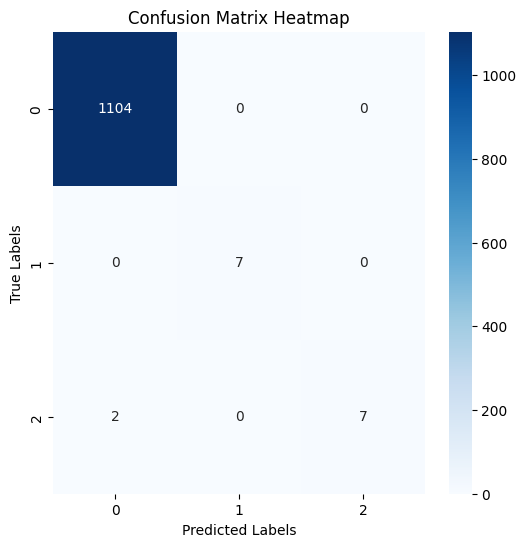

In [ ]:
# Assuming y_test and y_pred are your true and predicted labels respectively
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))  # Adjust figure size if needed
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix Heatmap")
plt.show()

In [ ]:
import pickle
filename = 'model.pkl'  # Choose a filename
with open(filename, 'wb') as file:
    pickle.dump(clf, file)